# Morphology prediction using abundance data only

This version uses Mark's U2OS abundance table

In [2]:
import pandas as pd

gene_labels = pd.read_csv('../data/cpg0016/version_2023-06-14/gene_labels.csv')

In [3]:
gene_labels

,Metadata_Symbol,Metadata_NCBI_Gene_ID,Indeterminate,Negative,Positive,gene_label
0,A2M,2,1,1,3,Positive
1,A3GALT2,127550,1,0,4,Positive
2,A4GALT,53947,0,0,5,Positive
3,A4GNT,51146,3,0,3,Indeterminate
4,AACS,65985,1,0,4,Positive
...,...,...,...,...,...,...
7970,ZSCAN32,54925,4,0,1,Indeterminate
7971,ZSCAN4,201516,0,0,3,Positive
7972,ZSCAN5A,79149,0,0,5,Positive
7973,ZSCAN9,7746,0,0,5,Positive


In [4]:
cell_line_df = pd.read_table('../../../data/cellular-localization/gene_abundances_U2OS.tsv')
cell_line_df

,Enesembl ID,Gene,RNA line ab,RNA type ab,protein type ab
0,ENSG00000000003,TSPAN6,23.4,NaN,NaN
1,ENSG00000000005,TNMD,0.0,NaN,NaN
2,ENSG00000000419,DPM1,97.8,NaN,NaN
3,ENSG00000000457,SCYL3,3.6,NaN,NaN
4,ENSG00000000460,C1orf112,16.1,NaN,NaN
...,...,...,...,...,...
20077,ENSG00000288677,AC105206.4,1.7,NaN,NaN
20078,ENSG00000288678,AL136115.4,0.0,NaN,NaN
20079,ENSG00000288681,AC136475.9,0.0,NaN,NaN
20080,ENSG00000288684,AL353671.1,0.7,NaN,NaN


In [5]:
undetected_df = pd.read_table('../../../data/cellular-localization/undetected_genes_U2OS.tsv')
undetected_df

,Enesembl ID,Gene
0,ENSG00000159455,LCE2B
1,ENSG00000141255,SPATA22
2,ENSG00000259303,IGHV2OR16-5
3,ENSG00000186930,KRTAP6-2
4,ENSG00000211967,IGHV3-53
...,...,...
4041,ENSG00000142973,CYP4B1
4042,ENSG00000188120,DAZ1
4043,ENSG00000111783,RFX4
4044,ENSG00000188730,VWC2


We will use the `RNA line ab` column and encode protein absence with a binary variable (absent=0, present=1):

In [9]:
abundance_df = cell_line_df[['Gene', 'RNA line ab']]
abundance_df.loc[:, 'Protein present'] = 1
abundance_df.loc[abundance_df['Gene'].isin(undetected_df['Gene']), 'Protein present'] = 0
abundance_df

/tmp/ipykernel_283762/2725172607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abundance_df.loc[:, 'Protein present'] = 1


,Gene,RNA line ab,Protein present
0,TSPAN6,23.4,1
1,TNMD,0.0,0
2,DPM1,97.8,1
3,SCYL3,3.6,1
4,C1orf112,16.1,1
...,...,...,...
20077,AC105206.4,1.7,1
20078,AL136115.4,0.0,0
20079,AC136475.9,0.0,0
20080,AL353671.1,0.7,1


Get definitively labeled subset of morphology data

In [10]:
definite_gene_labels = gene_labels[gene_labels.gene_label.isin(['Positive', 'Negative'])]
definite_gene_labels

,Metadata_Symbol,Metadata_NCBI_Gene_ID,Indeterminate,Negative,Positive,gene_label
0,A2M,2,1,1,3,Positive
1,A3GALT2,127550,1,0,4,Positive
2,A4GALT,53947,0,0,5,Positive
4,AACS,65985,1,0,4,Positive
5,AADAC,13,4,0,6,Positive
...,...,...,...,...,...,...
7969,ZSCAN31,64288,0,0,5,Positive
7971,ZSCAN4,201516,0,0,3,Positive
7972,ZSCAN5A,79149,0,0,5,Positive
7973,ZSCAN9,7746,0,0,5,Positive


Check if all symbols in labeled set are covered by the HPA data

In [11]:
definite_gene_labels.Metadata_Symbol.isin(abundance_df['Gene']).all()

False

How many are we missing?

In [12]:
definite_gene_labels.Metadata_Symbol[~definite_gene_labels.Metadata_Symbol.isin(abundance_df['Gene'])]

9          AARS
131        ACPP
132        ACPT
208       ADCK3
209       ADCK4
         ...   
7725       YARS
7740        ZAK
7765    ZCCHC11
7923     ZNF645
7953      ZNRD1
Name: Metadata_Symbol, Length: 128, dtype: object

For subsequent analysis, we'll use genes that are both labeled and have abundance data.

In [13]:
labeled_df = abundance_df.merge(
    definite_gene_labels[['Metadata_Symbol', 'gene_label']],
    how='inner',
    left_on='Gene',
    right_on='Metadata_Symbol'
)
labeled_df

,Gene,RNA line ab,Protein present,Metadata_Symbol,gene_label
0,DPM1,97.8,1,DPM1,Positive
1,SCYL3,3.6,1,SCYL3,Positive
2,FGR,0.0,0,FGR,Positive
3,FUCA2,52.1,1,FUCA2,Positive
4,GCLC,30.2,1,GCLC,Positive
...,...,...,...,...,...
6863,NR2E3,0.0,0,NR2E3,Positive
6864,MRM1,7.0,1,MRM1,Positive
6865,ADORA3,0.0,0,ADORA3,Negative
6866,PRSS50,0.0,0,PRSS50,Positive


Construct vectors for ML

In [14]:
x = labeled_df[['RNA line ab', 'Protein present']]
y = labeled_df['gene_label'].map({'Positive': 0, 'Negative': 1})

ML Run

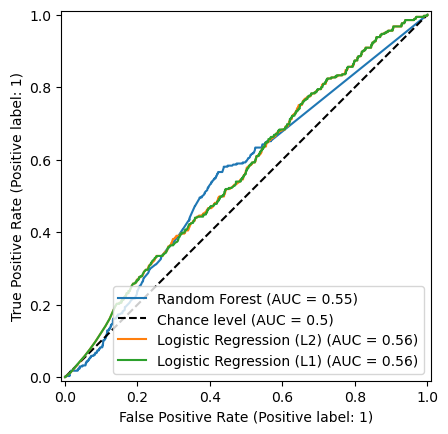

In [15]:
# Defining inputs for machine learning models
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize, LabelEncoder
from matplotlib.pyplot import subplots

models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression (L2)': LogisticRegression(penalty='l2'),
    'Logistic Regression (L1)': LogisticRegression(penalty='l1', solver='liblinear')
}

cv = StratifiedKFold(n_splits=10, random_state=20240131, shuffle=True)

ax = None

for name, model in models.items():
    probs = cross_val_predict(model, x, y, cv=cv, method='predict_proba')[:, 1]
    fig = RocCurveDisplay.from_predictions(y, probs, name=name, plot_chance_level=(ax is None), ax=ax)
    ax = fig.ax_